# Salary analysis
- We will perform the following:
    - Clean and reformat the data
    - Split data into train/test split
    - Create data pipeline to process data
    - Get performance of baseline model
    - Use k-fold CV to estimate the test performance metric (e.g., mean rmse across all CV folds) of several candidate models
    - For the "best" model with the highest test metric, perform hyperparameter tuning
        - Use RandomizedSearchCV to identify a set of potential optimal values for the hyperparameter. Refine the tuning with GridSearchCV. Get the mean CV score of the best model. Make predictions with the best model using the test set and get the test metric of the test set.
    - Use GridSearchCV to tune hyperparameters for multiple pipelines (which has the model as the last transformer in the pipeline).

In [1]:
import sys
import os
from pathlib import Path

'''data'''
import pandas as pd
import numpy as np

'''visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

'''feature engine'''
from feature_engine.imputation import CategoricalImputer

from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder)

from feature_engine.wrappers import SklearnTransformerWrapper

'''sklearn'''
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

'''models'''
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

'''performance evaluation'''
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

'''others'''
from random import sample # randomly sample elements from a list
import joblib # persist models

In [2]:
# set working directory to be one level above /notebook during the INIT RUN 
try: INIT_RUN
except NameError:
    os.chdir(os.path.dirname(os.getcwd()))
    INIT_RUN=True

## Project Parameters
- Gather all project parameters here, they will be set inside a yaml config file in a future iteration of this project

In [3]:
# get root and data directory of project
ROOT_DIR = os.getcwd()
RAW_DATA_DIR = Path(ROOT_DIR,"data","raw")
PROCESSED_DATA_DIR = Path(ROOT_DIR,"data","processed")

# Selected features
FEATURES = ["age_category","industry","state","city",
            "overall_experience","in_field_experience",
            "education","gender","race"]

# Modelling parameters
RANDOM = 10
TEST_SIZE = 0.2

# Custom lower bound for outlier removal
OUTLIER_LWR_BOUND = 5000


# Data pipeline
# Variables that I retain the X most frequent level and lump the rest as "Other"
CAT_VARS_10_MOST_FREQ = ["state","city","industry"]
CAT_VARS_2_MOST_FREQ = ["gender"]
CAT_VARS_4_MOST_FREQ = ["race"]

# impute missing values with "missing"
CATEGORICAL_VARS_WITH_NA_MISSING = ["industry","state","city","education","gender","race"]

# variable mappings (string to integer encoding)
EXPERIENCE_VARS = ["overall_experience","in_field_experience"]
AGE_VARS = ["age_category"]

# one-hot encoding
NOMINAL_VARIABLES = ["industry","state","city","gender","race","education"]

# Fit Gradient boosted tree and random forest models
EXECUTE = True

## Helper functions
- Will be placed in a separate module later on

In [4]:
def parse_num_get_levels(df,col):
    ordered_levels = (df[col]
    .value_counts()
    .reset_index()
    .rename(columns={'index':'levels'})
     # extract the first one (or more) digits
    .assign(num_levels=lambda x: x.levels.str.extract(r'(\d+)').astype(int))
    .sort_values("num_levels")
    .levels
    .tolist())
    
    # create categorical type
    categorical_type =  pd.api.types.CategoricalDtype(
    categories=ordered_levels,
    ordered=True)
    
    # convert col to ordered categorical type
    df[col] = df[col].astype(categorical_type)

In [5]:
def remove_outlier(df_in, col_name, lwr_bound =None, upr_bound=None):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    
    if lwr_bound is None:
        lwr_bound  = q1-1.5*iqr
    
    if upr_bound is None:
        upr_bound = q3+1.5*iqr
    
    df_out = df_in.loc[(df_in[col_name] > lwr_bound) & (df_in[col_name] < upr_bound)]
    return df_out

In [6]:
# define models to test
def get_models():
    # init list of models with associated names
    models,names = list(), list()
    
    # linear regression
    models.append(LinearRegression())
    names.append("linear_regression")
    
    # Random Forest Regressor
    models.append(RandomForestRegressor())
    names.append("random_forest")
    
    # Gradient Boosted Trees
    models.append(GradientBoostingRegressor())
    names.append("gradient_boosting")
    
    return models, names

In [7]:
# Evaluate a model with k-fold cross validation
def evaluate_model(X,y,model):
    scores = cross_val_score(
        estimator = model,
        X = X,
        y = y,
        cv = 10,
        scoring = "neg_root_mean_squared_error",
        n_jobs=-1)
    
    return scores

### Custom transformer
- Map string levels to numeric levels

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

# Categorical variables encoding (the encoding of categorical variables that already have ordered
# levels from strings to numeric)

class Mapper(BaseEstimator, TransformerMixin):
    """
    Constructor

    Args:
        variables (List[str]): a list of variables to be recoded (specified by user)
        mappings (dict): a dictionary of mappings from old to new encoding

    Returns:
        void
    """

    def __init__(self, variables, mappings):

        # Error handling: check to ensure variables is a list
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        # Error handling: check to ensure variables is a dict
        if not isinstance(mappings, dict):
            raise ValueError('mapping should be a dictionary')

        # set attributes at instantiation of class
        self.variables = variables
        self.mappings = mappings

    def fit(self, X,
            y=None):  # need to have y as argument to make class compatible with sklearn pipeline
        """ Fit

        Args:
            X (DataFrame): a input dataframe of features to train the transformer
            y (DataFrame): a input Series of response variable to train the transformer (optional)

        Returns:
            self
        """
        # We don't need to learn any parameters for this transformer. Nonetheless, we still need
        # to include a fit method so that the Transformer class would be compatible to sklearn

        return self

    def transform(self, X):
        """ Transform

        Args:
            X (DataFrame): a input dataframe of features to be transformed

        Returns:
            X (DataFrame): the transformed Dataframe of features
        """

        # Make a copy of the input Dataframe of features to be transformed
        # so we won't overwrite the original Dataframe that was passed as argument
        X = X.copy()

        # Perform recoding of the levels of var
        for var in self.variables:
            X[var] = X[var].map(self.mappings)

        return X

## Import data

In [9]:
survey = pd.read_csv(Path(RAW_DATA_DIR,"survey.csv"))

In [10]:
# We will only focus on respondents (>83% of them) that are paid in USD
survey_usd = survey.loc[survey["currency"]=='USD'].copy()

In [11]:
# categorical variables and numeric variables
cat_vars = [var for var in survey_usd.columns if survey_usd[var].dtype=='O']
num_vars = [var for var in survey_usd.columns if survey_usd[var].dtype!='O']

## Clean and reformat data
- Convert timestamp to datetime
- Reformat state, overall_experience, in_field_experience, and age, and convert these variables to ordered categorical variables
- Rename variables
- Remove outliers (5000,75th percentile+3*IQR)    

**These are steps that do not have to be included in a data pipeline (does not cause data leakage). Let's implement these steps here.** 

In [12]:
# Convert timestamp to datetime
survey_usd.loc[:,'timestamp'] = survey_usd.loc[:,'timestamp'].astype('datetime64[ns]')

# state
# Only take the first state in the response and ignore the rest
survey_usd["state"]=survey_usd["state"].str.split(',').str[0]

# overall_years_of_professional_experience
survey_usd['overall_years_of_professional_experience'] = (survey_usd['overall_years_of_professional_experience']
                                                      .str
                                                      .replace(' - ','-'))

parse_num_get_levels(survey_usd,
                     "overall_years_of_professional_experience")

# years_of_experience_in_field
survey_usd['years_of_experience_in_field'] = (survey_usd['years_of_experience_in_field']
                                                      .str
                                                      .replace(' - ','-'))

parse_num_get_levels(survey_usd,
                     "years_of_experience_in_field")


# age

# Need to rename the "under 18" level to "17 or under" so it can be parsed by the parse_num_get_levels() function
survey_usd["how_old_are_you"]=survey_usd["how_old_are_you"].replace(to_replace = "under 18",
                                                                   value="17 or under")

parse_num_get_levels(survey_usd,
                     "how_old_are_you")

# rename variables
survey_usd=survey_usd.rename(columns={"how_old_are_you": "age_category",
                                      "overall_years_of_professional_experience":"overall_experience",
                                      "years_of_experience_in_field": "in_field_experience",
                                      "highest_level_of_education_completed":"education"},                             
                             errors="raise")

# Remove outliers
survey_usd = remove_outlier(df_in = survey_usd, 
                            col_name = "annual_salary",
                            lwr_bound = 5000)

**Get a dictionary that maps the ordered levels of overall_experience (note: in_field_experience has the same levels) to an integer ordered from (0,number of levels -1). This will be used in the recoding transformer that will be used on overall_experience and in_field_experience**

In [13]:
temp=dict(enumerate(survey_usd['overall_experience'].cat.categories))

# Set key to value and value to key as per the requirements of 
# .map() method used in Mapper transformer in preprocessing.py
DICT_EXPERIENCE_ORDERED_LEVELS = {v: k for k, v in temp.items()}

In [14]:
DICT_EXPERIENCE_ORDERED_LEVELS

{'1 year or less': 0,
 '2-4 years': 1,
 '5-7 years': 2,
 '8-10 years': 3,
 '11-20 years': 4,
 '21-30 years': 5,
 '31-40 years': 6,
 '41 years or more': 7}

**Get a dictionary that maps the ordered levels of age_category to an integer ordered from (0,number of levels -1). This will be used in the Mapper function for age.**

In [15]:
temp=dict(enumerate(survey_usd['age_category'].cat.categories))
DICT_AGE_ORDERED_LEVELS= {v: k for k, v in temp.items()}

In [16]:
DICT_AGE_ORDERED_LEVELS

{'17 or under': 0,
 '18-24': 1,
 '25-34': 2,
 '35-44': 3,
 '45-54': 4,
 '55-64': 5,
 '65 or over': 6}

## Test train split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    survey_usd.drop(["annual_salary"], axis="columns"), # features
    survey_usd["annual_salary"], # target
    test_size = TEST_SIZE,
    random_state = RANDOM
)

X_train.shape, X_test.shape

((16734, 17), (4184, 17))

**Apply log transformation on DV**

In [18]:
y_train = np.log(y_train)
y_test = np.log(y_test)

**Get data subset of selected features**

In [19]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

## Data pipeline

- We need to impute missing values for 6 features with a new level called "missing".
- Lump the rare levels of the following categorical variables to "Other":
    - state
    - city
    - race 
    - gender 
    - industry 
- Map string encoding to integer encoding for the following ordinal variables:
    - overall_experience
    - in_field_experience
    - age_category
- One hot encode nominal features    

In [20]:
salary_pipeline = Pipeline([
    
    
    # === Imputation ===
    # Imputing missing values in categorical variables (with a new "missing" level)
    # CategoricalImputer from feature_engine
    ('missing_imputation', CategoricalImputer(imputation_method='missing',
                                             variables=CATEGORICAL_VARS_WITH_NA_MISSING)),
    
    
    # === Recoding categorical variables ===
    ("rare_label_encoder_10", RareLabelEncoder(tol=0.01,
                                            max_n_categories = 10,
                                            n_categories=1,
                                            replace_with = "Other",
                                            variables = CAT_VARS_10_MOST_FREQ)),
    
    ("rare_label_encoder_2", RareLabelEncoder(tol=0.01,
                                            max_n_categories = 2,
                                            n_categories=1,
                                            replace_with = "Other",
                                            variables = CAT_VARS_2_MOST_FREQ)),
    
    ("rare_label_encoder_4", RareLabelEncoder(tol=0.01,
                                            max_n_categories = 4,
                                            n_categories=1,
                                            replace_with = "Other",
                                            variables = CAT_VARS_4_MOST_FREQ)),
    
    # === Recoding categorical variables with ordered level ===
    
    # Recode categorical variables with ordered level: map from string encoding to numeric encoding
    # Use custom class from 'preprocessing.py' Mappers
    ('mapper_exp',Mapper(
        variables=EXPERIENCE_VARS, mappings=DICT_EXPERIENCE_ORDERED_LEVELS)),

    ('mapper_age', Mapper(
        variables=AGE_VARS, mappings=DICT_AGE_ORDERED_LEVELS)),
    
     # === One-hot enccode nominal variables ===
    ('one_hot_encoder', OneHotEncoder(drop_last=True, # avoid dummy variable trap
                                      variables = NOMINAL_VARIABLES))
    

])                    

In [21]:
# Fit pipeline to train data
salary_pipeline.fit(X_train,y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['industry', 'state', 'city',
                                               'education', 'gender',
                                               'race'])),
                ('rare_label_encoder_10',
                 RareLabelEncoder(max_n_categories=10, n_categories=1,
                                  replace_with='Other', tol=0.01,
                                  variables=['state', 'city', 'industry'])),
                ('rare_label_encoder_2',
                 RareLabelEncoder(max_n_categories=2, n_categories=1,
                                  rep...
                                  '31-40 years': 6, '41 years or more': 7,
                                  '5-7 years': 2, '8-10 years': 3},
                        variables=['overall_experience',
                                   'in_field_experience'])),
                ('mapper_age',
                 Mapper(mappings={'17 or under': 0, '18-24': 1, '25-34': 2,
                                  '35-44': 3, '45-54': 4, '55-64': 5,
                                  '65 or over': 6},
                        variables=['age_category'])),
                ('one_hot_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['industry', 'state', 'city', 'gender',
                                          'race', 'education']))])

## Save the processed data

In [22]:
# Transform X_train and X_test with the fitted pipeline
X_train = salary_pipeline.transform(X_train)
X_test = salary_pipeline.transform(X_test)

In [23]:
# save the column names of the processed X_train data
feature_columns = X_train.columns.values 

In [24]:
# Save the processed X_train, X_test, y_train and y_test
X_train.to_csv(Path(PROCESSED_DATA_DIR,"X_train.csv"))
X_test.to_csv(Path(PROCESSED_DATA_DIR,"X_test.csv"))

y_train.to_csv(Path(PROCESSED_DATA_DIR,"y_train.csv"))
y_test.to_csv(Path(PROCESSED_DATA_DIR,"y_test.csv"))

# Modelling

## 00- Baseline model
- A naive guess of what the employee salary are. We make the same predictions for each employee-- the median salary across all employees in the train (and test) data.
- Having a baseline prediction will allow us to see how much of an improvement I can get if I use an statistical learning approach. If the improvement is very small, then perhaps statistical learning is not a suitable approach for this problem.

In [25]:
baseline_pred = np.median(np.log(survey_usd["annual_salary"]))
# make this into a pd.Series with the same length as y_test
y_pred_baseline = pd.Series(baseline_pred).repeat(y_test.shape[0])
y_pred_baseline

0    11.240867
0    11.240867
0    11.240867
0    11.240867
0    11.240867
       ...    
0    11.240867
0    11.240867
0    11.240867
0    11.240867
0    11.240867
Length: 4184, dtype: float64

In [26]:
print(f"The rmse of the baseline model is {round(mean_squared_error(y_test,y_pred_baseline, squared=False),2)}")

The rmse of the baseline model is 0.47


**Alternatively, use sklearn.DummyRegressor**

In [27]:
# Init the dummy regressor
dummy_regr = DummyRegressor(strategy="median")
# Train the model
dummy_regr.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [28]:
# Make predictions and get baseline performance
y_pred_baseline=dummy_regr.predict(X_test)
print(f"The rmse of the baseline model is {round(mean_squared_error(y_test,y_pred_baseline, squared=False),2)}.")

The rmse of the baseline model is 0.47.


## 1. Train the following models: linear regression, random forest, gradient boosting and compare their estimated test metric (k-fold cv scores)

**Init models**

In [29]:
models, names = get_models()

In [30]:
models, names

([LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor()],
 ['linear_regression', 'random_forest', 'gradient_boosting'])

**Evaluate models**

In [31]:
# Evaluate each model (get estimated test metric) and store the results in a list "l_mean_cv_scores"
l_cv_scores = list()
for model, name in list(zip(models, names)):
    
    # Compute cv scores of each model
    cv_scores = evaluate_model(X_train, y_train, model)
    
    # Update the list of model results, each row represent the cv scores of a model
    l_cv_scores.append(cv_scores)

    # Summary of model performance
    print((name, round(-cv_scores.mean(),2), round(np.std(cv_scores),2)))

('linear_regression', 0.35, 0.01)
('random_forest', 0.38, 0.01)
('gradient_boosting', 0.36, 0.01)


Text(0, 0.5, 'negative rmse')

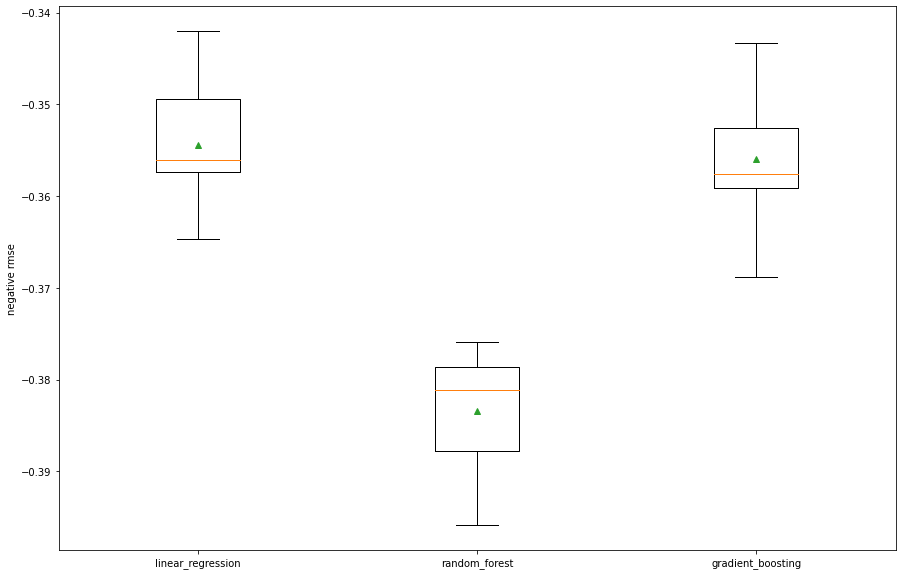

In [32]:
fig = plt.figure(figsize=(15,10))
plt.boxplot(l_cv_scores, labels=names, showmeans=True)
plt.ylabel("negative rmse")

- Linear regression model has the best performance-- it has the least rmse (average percent deviation of data from geometric mean of annual salary across all train observations)
- We can tune random forest and gradient boosting to see if the tuned models can outperform linear regression.

## 2. Hyperparameter tuning for random forest and gradient boosted trees
- Here, I will tune both the random forest and gradient boosted tree models

### Random Forest

In [33]:
reg = RandomForestRegressor()

**RandomizedSearchCV for Random Forest**

In [34]:
random_grid = {
   "n_estimators": [10, 100, 1000],
    "max_features": ['sqrt','log2'],
    "max_depth": [None,1,3,10,40,50],
    "min_samples_split": [2,5,10,50,100],
    "min_samples_leaf": [2,5,10,50,100]
}

In [35]:
# Perform random search of the parameters, using a 10 fold CV to estimate the test metric for each setting.
rand_grid_search = RandomizedSearchCV(estimator = reg,
                                param_distributions = random_grid,
                                n_iter = 20,  # randomly select 20 different settings to try
                                cv = 10,       # use 10-fold CV for each setting to estimate its test metric
                                scoring="neg_root_mean_squared_error",
                                verbose = 1, #2   # show the process
                                n_jobs =-1,  # use all processors
                                random_state = RANDOM)

In [36]:
rand_grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 1, 3, 10, 40, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [2, 5, 10, 50, 100],
                                        'min_samples_split': [2, 5, 10, 50,
                                                              100],
                                        'n_estimators': [10, 100, 1000]},
                   random_state=10, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [37]:
print(f"The mean CV score (rmse) of the best estimator is: {-rand_grid_search.best_score_}")
print(f"The best alpha for the rf model from RandomGridSearch is {rand_grid_search.best_params_}") 

The mean CV score (rmse) of the best estimator is: 0.357108796399515
The best alpha for the rf model from RandomGridSearch is {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40}


**GridSearchCV for Random Forest**

In [38]:
reg = RandomForestRegressor(n_estimators=1000,
                           max_features="sqrt")

In [39]:
param_grid = {
    "max_depth": [35,40,45],
    "min_samples_split": [4,5,6],
    "min_samples_leaf": [1,2,3]
}

In [40]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, 
                           param_grid = param_grid, 
                           cv = 10, 
                           scoring="neg_root_mean_squared_error",
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [41]:
if EXECUTE:
    grid_search.fit(X_train,y_train)
    
    # The optimal parameter
    print(f"The optimal parameter from GridSearchCV is: {grid_search.best_params_}")

    # The score of the model with the optimal parameter
    print(f"\nThe mean CV score (rmse) of the model with the best parameter is: {-grid_search.best_score_}")
    
    # Get the model that uses the "best" hp, trained from the full train set
    best_reg = grid_search.best_estimator_

    # Make predictions using X_test
    y_pred = best_reg.predict(X_test)
    
    # Evaluate the performance of the model (rmse) with the test set
    print(f"The test rmse of the tuned model estimated using the test set is: {round(mean_squared_error(y_test,y_pred,squared=False),2)}")

Fitting 10 folds for each of 27 candidates, totalling 270 fits
The optimal parameter from GridSearchCV is: {'max_depth': 35, 'min_samples_leaf': 3, 'min_samples_split': 6}

The mean CV score (rmse) of the model with the best parameter is: 0.35676027115097075
The test rmse of the tuned model estimated using the test set is: 0.36


### Gradient Boosted Trees

In [42]:
reg = GradientBoostingRegressor()

**RandomizedSearchCV for gb**

In [43]:
random_grid = {
   "n_estimators": [100, 500, 1000], # number of trees to build
   "learning_rate": [0.01,0.05,0.1], # learning rate
   "max_depth":[4,6,8,10], # maximum depth of each tree
   "subsample":[0.5,0.75,1.0], # prop of train set (observations) to consider for each tree
   "max_features":[0.4,0.6,0.8,1.0] # prop of features to consider for each split
}

In [44]:
# Perform random search of the parameters, using a 10 fold CV to estimate the test metric for each setting.
rand_grid_search = RandomizedSearchCV(estimator = reg,
                                param_distributions = random_grid,
                                n_iter = 20,  # randomly select 20 different settings to try
                                cv = 10,       # use 10-fold CV for each setting to estimate its test metric
                                scoring="neg_root_mean_squared_error",
                                verbose = 1, #2   # show the process
                                n_jobs =-1,  # use all processors
                                random_state = RANDOM)

In [45]:
rand_grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': [0.4, 0.6, 0.8, 1.0],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.5, 0.75, 1.0]},
                   random_state=10, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [46]:
print(f"The mean CV score (rmse) of the best estimator is: {-rand_grid_search.best_score_}")
print(f"The best alpha for the gb model from RandomGridSearch is {rand_grid_search.best_params_}") 

The mean CV score (rmse) of the best estimator is: 0.3508543676246644
The best alpha for the gb model from RandomGridSearch is {'subsample': 1.0, 'n_estimators': 1000, 'max_features': 0.4, 'max_depth': 4, 'learning_rate': 0.05}


**GridSearchCV for Gradient Boosted trees**

In [47]:
reg = GradientBoostingRegressor(n_estimators=1000,
                                subsample=1.0)

In [48]:
param_grid = {
    "learning_rate":[0.02,0.05,0.08],
    "max_depth": [3,4,5],
    "max_features": [0.3,0.4,0.5]
}

In [49]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, 
                           param_grid = param_grid, 
                           cv = 10, 
                           scoring="neg_root_mean_squared_error",
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [50]:
if EXECUTE:
    grid_search.fit(X_train,y_train)
    
    # The optimal parameter
    print(f"The optimal parameter from GridSearchCV is: {grid_search.best_params_}")

    # The score of the model with the optimal parameter
    print(f"\nThe mean CV score (rmse) of the model with the best parameter is: {-grid_search.best_score_}")
    
    # Get the model that uses the "best" hp, trained from the full train set
    best_reg = grid_search.best_estimator_
    # Make predictions using X_test
    y_pred = best_reg.predict(X_test)
    
    # Evaluate the performance of the model (rmse) with the test set
    print(f"The test rmse of the tuned model estimated using the test set is: {round(mean_squared_error(y_test,y_pred,squared=False),2)}")

Fitting 10 folds for each of 27 candidates, totalling 270 fits
The optimal parameter from GridSearchCV is: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 0.3}

The mean CV score (rmse) of the model with the best parameter is: 0.3504984231307054
The test rmse of the tuned model estimated using the test set is: 0.35


**By tuning hyperparameters, the performance of random forest and gb is close to linear regression model (close to 0.35). However, since linear regression has fast training time and interpretible, we should use linear regression.**

## 3. Tune data pipelines that uses Random Forest and Gradient boosted trees models

- Instead of transforming X_train, X_test with the data pipeline to get "processed" data, and then use the processed data to train models, I can directly use data pipelines (with models as the last step) in GridSearchCV
- An additional advantage of using pipelines in GridSearchCV is that we can tune parameters in the data processing steps as well (e.g., rare labels labelling-- number of levels to keep, or parameters in tfidf)

### Test harness

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    survey_usd.drop(["annual_salary"], axis="columns"), # features
    survey_usd["annual_salary"], # target
    test_size = TEST_SIZE,
    random_state = RANDOM
)

X_train.shape, X_test.shape

((16734, 17), (4184, 17))

In [52]:
y_train = np.log(y_train)
y_test = np.log(y_test)

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

**A list of models to tune**

In [53]:
models = {
    "random_forest": RandomForestRegressor(n_estimators=1000,
                                            max_features="sqrt"),
    "gradient_boosting": GradientBoostingRegressor(n_estimators=1000,
                                               subsample=1.0)    
}

**Hyperparameters for data processing steps in pipeline (if any) and for each model**

In [54]:
# A dict of dicts
param_grid = {
    # == random forest ==
    "random_forest": {
        "regressor__max_depth": [35,40,45],
        "regressor__min_samples_split":[4,5,6],
        "regressor__min_samples_leaf":[1,2,3]    
    },
    # == gradient boosting ==
    "gradient_boosting":{
        "regressor__learning_rate": [0.02,0.05,0.08],
        "regressor__max_depth": [3,4,5],
        "regressor__max_features": [0.3,0.4,0.5]        
    }
}

In [55]:
if EXECUTE:
    results=[] # init a list that contains results for each model

    for model_name in models.keys():
       
        # append current model to pipeline as the last step (ex: 'regressor, RandomForestRegressor()')
        salary_pipeline.steps.append(['regressor', models[model_name]])
    
        # Get the params for the current model
        params = param_grid[model_name]
    
        # Init GridSearchCV 
        grid = GridSearchCV(estimator = salary_pipeline, 
                            param_grid = params, 
                            cv = 5, 
                            scoring="neg_root_mean_squared_error",
                            verbose =1, # show the process
                            n_jobs = -1)  # n_jobs = -1 means use all processors    
    
        # Fit GridSearchCV
        grid.fit(X_train, y_train)
    
        # remove last step (model) of the pipeline so it can be reused for the next iter (model)
        salary_pipeline=salary_pipeline[:-1]
    
        # Collect results of GridSearchCV
        results.append({
            'model_name': model_name,
            'grid': grid,
            'best_estimator': grid.best_estimator_,
            'best_score': grid.best_score_,
            'best_params': grid.best_params_
        })
        
        # Persist model
        joblib.dump(grid.best_estimator_,Path(ROOT_DIR,"models",f"{model_name}.joblib"))

    # Look at results
    df_results = pd.DataFrame(results)
    df_results = (df_results
                  .rename(df_results["model_name"],axis="index"))
    df_results["best_score"] = -1*df_results["best_score"]
    

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [56]:
df_results

,model_name,grid,best_estimator,best_score,best_params
random_forest,random_forest,"GridSearchCV(cv=5,\n estimator=Pip...","(CategoricalImputer(variables=['industry', 'st...",0.357052,"{'regressor__max_depth': 35, 'regressor__min_s..."
gradient_boosting,gradient_boosting,"GridSearchCV(cv=5,\n estimator=Pip...","(CategoricalImputer(variables=['industry', 'st...",0.351383,"{'regressor__learning_rate': 0.05, 'regressor_..."


**Both the tuned random forest and gradient boosting have a similar rmse to the linear regression model (0.35). The performance (rmse) is not very different across the three model. Due to the simplicity, low training time and computational requirement, and interpretibility of the linear regression model, I will select this model for this problem.**

## 4. Feature importance from Random Forest

In [57]:
# load best random forest model pipeline
best_rf_pipeline=joblib.load(Path(ROOT_DIR,"models","random_forest.joblib"))
# Get best random forest model
best_rf= best_rf_pipeline.named_steps["regressor"]

In [58]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_columns, 
                                'importance': best_rf.feature_importances_})

<AxesSubplot:title={'center':'Feature importance from random forest'}, ylabel='relative feature importance'>

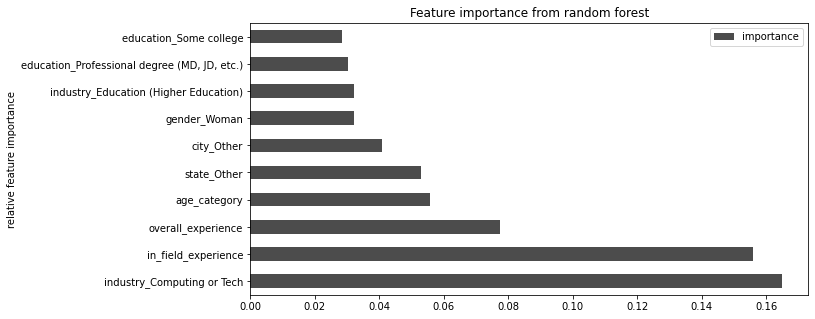

In [59]:
# Bar plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

(feature_results
     .sort_values("importance", ascending=False)
     .set_index("feature")
     .head(10)
     .plot.barh(
         ax=ax,
         color='k',
         alpha=0.7,
         title="Feature importance from random forest",
         xlabel="relative feature importance",
         ylabel="features"         
     ))

**There are only a few important determinants of annual salary (from random forest model): being in the computing or tech industry, years of experience and work: (in field experience, overall experience and age). Gender and education level matters but to a relatively smaller extent.**

## 5. Linear Regression Output
- Use linear regression from statsmodel to output regression table, and then write it as a TeX or .txt file using stargazer

In [60]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [61]:
# Get processed data
X_train_processed = salary_pipeline.fit_transform(X_train, y_train)
X_test_processed = salary_pipeline.transform(X_test)

In [62]:
# Init the OLS model object
X_train_processed = sm.add_constant(X_train_processed) # sm does not automatically add constant to predictors
feat_names = list(X_train_processed.columns.values)
 
regr = sm.OLS(y_train,
              X_train_processed)

In [63]:
res = regr.fit()
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     249.8
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:19:39   Log-Likelihood:                -6340.9
No. Observations:               16734   AIC:                         1.277e+04
Df Residuals:                   16688   BIC:                         1.313e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [64]:
## Use Stargazer to render regression output

In [65]:
# res must be a sm.ols fitted model with pd.Series (DV) and pd.Dataframe (IV) inputs
stargazer = Stargazer([res])

# Customize the regression table
stargazer.title('Salary survey analysis') # custom title
stargazer.show_confidence_intervals(True) # show 95% CI
stargazer.rename_covariates({'city_Boston': 'city:Boston'})

In [66]:
stargazer

**Render html code using stargazer and output .html file**

In [67]:
# I can render latex code, or html code and write it onto a file
html_code=stargazer.render_html()

In [68]:
html_file = open(Path("outputs","linear_regression_results.html"), "w")
_n = html_file.write(html_code)
html_file.close()

**Render LaTeX code using stargazer and output .tex file**

In [69]:
tex_code=stargazer.render_latex()

In [70]:
tex_file = open(Path("outputs","linear_regression_results.tex"), "w")
_n = tex_file.write(tex_code)
tex_file.close()